This notebook runs the list-learning behavioral analyses

## Import libraries

In [1]:
from warnings import filterwarnings
import numpy as np
import pandas as pd
import quail
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr

from sherlock_helpers.constants import DATA_DIR, FIG_DIR, HAND_REC
from sherlock_helpers.functions import pearsonr_ci, show_source

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Helper functions and variables used across multiple notebooks can be found in `/mnt/code/sherlock_helpers/sherlock_helpers`, or on GitHub, [here](https://github.com/ContextLab/sherlock-topic-model-paper/tree/master/code/sherlock_helpers).<br />You can also view source code directly from the notebook with:<br /><pre>    from sherlock_helpers.functions import show_source<br />    show_source(foo)</pre>

## Define/inspect some functions

In [2]:
show_source(pearsonr_ci)

In [3]:
def plot_reg(x, y, data, ci=95, n_boots=1000, **jointplot_kwargs):
    xvals, yvals = df[x], df[y]
    dof = xvals.shape[0] - 2
    r, p = pearsonr(xvals, yvals)
    ci_low, ci_high = pearsonr_ci(xvals, yvals, ci=ci, n_boots=n_boots)
    if p < 0.001:
        pval = 'p < 0.001'
    else:
        pval = f'p = {round(p, 3)}'
        
    print(f"Pearson's r({dof}) = {r:.2f}, "
          f"{pval}, "
          f"{ci}% Confidence Intervals = ({round(ci_low, 2)}, {round(ci_high, 2)})")
    sns.jointplot(x=x, y=y, data=data, ci=ci, n_boot=n_boots, **jointplot_kwargs)
    plt.show()

## Set plot parameters

In [4]:
mpl.rcParams['pdf.fonttype'] = 42
palette = 'bone'

## Filter some harmless warnings

In [5]:
# pandas.DataFrame.get_values() was deprecated for container's pandas version
filterwarnings('ignore', "The 'get_values' method is deprecated", FutureWarning, module='quail.analysis.recmat')
# averaging across lags for lag-CRP where all are nans
filterwarnings('ignore', "Mean of empty slice", RuntimeWarning, module='quail.analysis')
# seaborn.JointGrid stat annotation was deprecated for container's seaborn version.
filterwarnings('ignore', "JointGrid annotation is deprecated", UserWarning, module='seaborn.axisgrid')

## Load data

In [6]:
video_events = np.load(DATA_DIR.joinpath('video_events.npy'))
recall_events = np.load(DATA_DIR.joinpath('recall_events.npy'), allow_pickle=True)

## Convert to egg format

In [7]:
pres = [[[{'item' : i, 'topics' : m} for i, m in enumerate(video_events)]] for sub in range(17)]

rec = []
for r in recall_events:
    items = list(np.argmax(1 - cdist(video_events, r, 'correlation'), 0).astype(int))
    rec.append([[{'item' : item, 'topics' : t} for item, t in zip(items, r)]])

## Make the egg

In [8]:
egg = quail.Egg(pres=pres, rec=rec)
egg.info()

Number of subjects: 17
Number of lists per subject: 1
Number of words per list: 30
Date created: Wed Oct 14 21:58:54 2020
Meta data: {}


## Run probability of first recall, lagcrp and serial position curve analyses, and create a figure

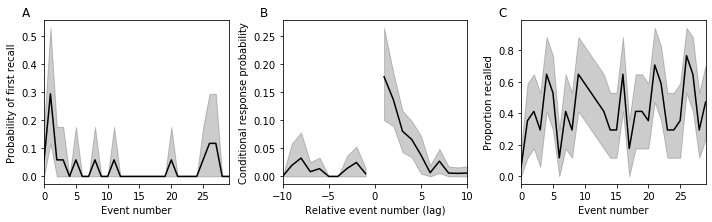

In [9]:
fig, axarr = plt.subplots(1, 3)
fig.set_size_inches(10, 3)

analysis = ['pfr', 'lagcrp', 'spc']
res = {}
for ax, a in zip(axarr, analysis):
    res[a] = egg.analyze(a, match='best', features=['topics'], 
                distance='correlation')
    res[a].plot(show=False, ax=ax, legend=False, palette=palette)
        
# make some adjustments
axarr[0].set_xlabel('Event number')
axarr[0].set_ylabel('Probability of first recall')

axarr[1].set_xlim(-10, 10)
axarr[1].set_xlabel('Relative event number (lag)')
axarr[1].set_ylabel('Conditional response probability')

axarr[2].set_xlabel('Event number')
axarr[2].set_ylabel('Proportion recalled')

plt.subplots_adjust(wspace=.45, hspace=.75)
plt.tight_layout()

# add labels
label=['A', 'B', 'C']
for ax, l in zip(axarr, label):
    ax.text(-.1, 1.025, 
           l,
           horizontalalignment='center',
           transform=ax.transAxes,
           fontsize=12)
# plt.savefig(FIG_DIR.joinpath('list_learning.pdf'), bbox_inches='tight')
plt.show()

## Cluster analyses

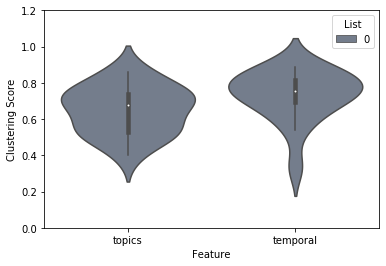

In [10]:
clustering = egg.analyze('fingerprint')
clustering.plot(ylim=[0, 1.2], palette=palette)
plt.show()

## SEM of clustering scores

In [11]:
sem = clustering.get_data().std() / np.sqrt(17)
print('Mean clustering score:\n', clustering.get_data().mean(), end='\n\n')
print('SEM:\n', sem, end='\n\n')
print('Mean + SEM:\n', clustering.get_data().mean() + sem, end='\n\n')
print('Mean - SEM:\n', clustering.get_data().mean() - sem)

Mean clustering score:
 topics      0.650252
temporal    0.731513
dtype: float64

SEM:
 topics      0.031653
temporal    0.033773
dtype: float64

Mean + SEM:
 topics      0.681905
temporal    0.765287
dtype: float64

Mean - SEM:
 topics      0.618599
temporal    0.697740
dtype: float64


## Create a dataframe containing the analysis results

In [12]:
df = pd.DataFrame({
    'Temporal clustering': clustering.data.temporal.values,
    'Semantic clustering': clustering.data.topics.values,
    'Number of events (k)': [r.shape[0] for r in recall_events],
    'Memory performance - hand': HAND_REC,
    'Memory performance - auto': res['spc'].data.mean(axis=1).values
})

In [13]:
reg_kwargs = {
    'data': df,
    'ci': 95,
    'n_boots': 10000,
    'kind': 'reg',
    'space': 0,
    'color': 'k'
}

## Correlation between hand annotated memory and memory estimated from the model across subjects

Pearson's r(15) = 0.71, p = 0.002, 95% Confidence Intervals = (0.39, 0.88)


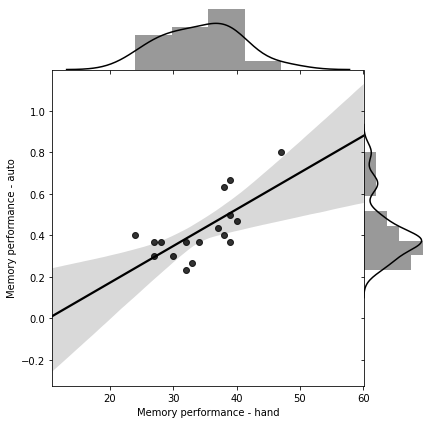

In [14]:
plot_reg(x='Memory performance - hand', y='Memory performance - auto', **reg_kwargs)

## Correlation between hand annotated memory and k (number of events) across subjects

Pearson's r(15) = 0.65, p = 0.004, 95% Confidence Intervals = (0.2, 0.88)


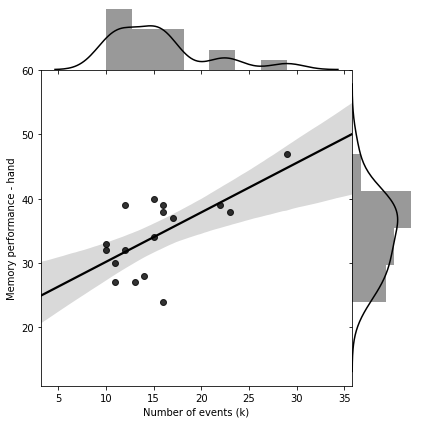

In [15]:
plot_reg(x='Number of events (k)', y='Memory performance - hand', **reg_kwargs)

## Correlation between hand annotated memory and temporal clustering

Pearson's r(15) = 0.49, p = 0.046, 95% Confidence Intervals = (0.25, 0.76)


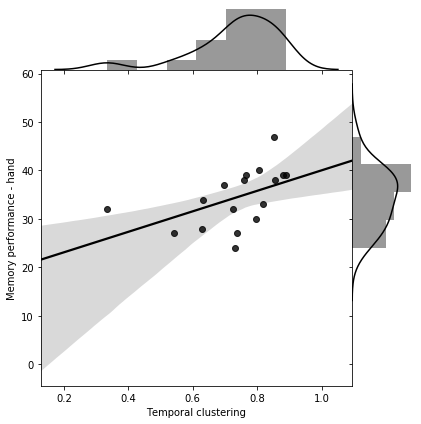

In [16]:
plot_reg(x='Temporal clustering', y='Memory performance - hand', **reg_kwargs)

## Correlation between model-estimated memory and temporal clustering

Pearson's r(15) = 0.59, p = 0.013, 95% Confidence Intervals = (0.31, 0.8)


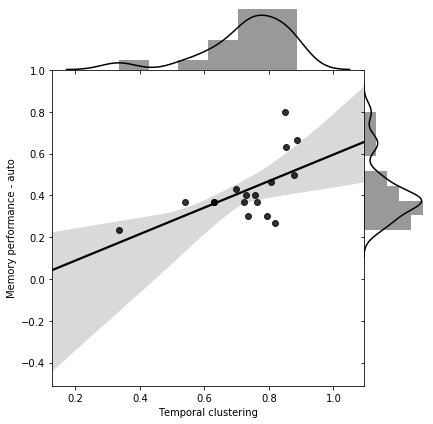

In [17]:
plot_reg(x='Temporal clustering', y='Memory performance - auto', **reg_kwargs)

## Correlation between k (number of events) and temporal clustering

Pearson's r(15) = 0.52, p = 0.032, 95% Confidence Intervals = (0.21, 0.75)


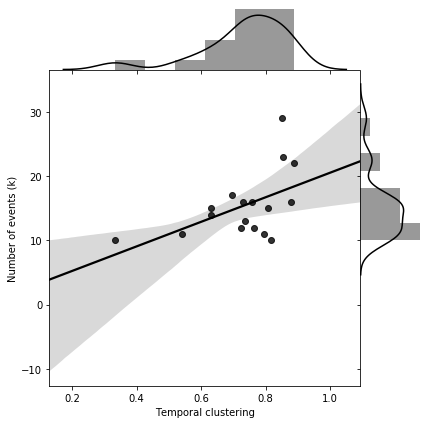

In [18]:
plot_reg(x='Temporal clustering', y='Number of events (k)', **reg_kwargs)

## Correlation between hand annotated memory and semantic clustering

Pearson's r(15) = 0.65, p = 0.004, 95% Confidence Intervals = (0.31, 0.85)


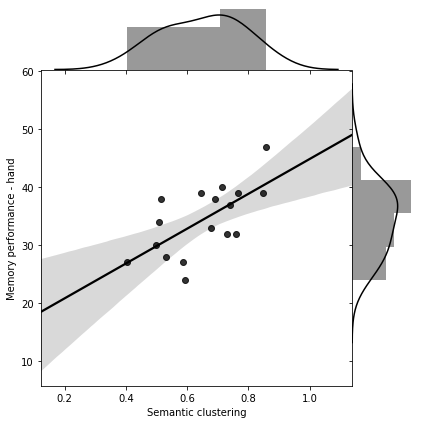

In [19]:
plot_reg(x='Semantic clustering', y='Memory performance - hand', **reg_kwargs)

## Correlation between model-estimated memory and semantic clustering

Pearson's r(15) = 0.58, p = 0.015, 95% Confidence Intervals = (0.1, 0.83)


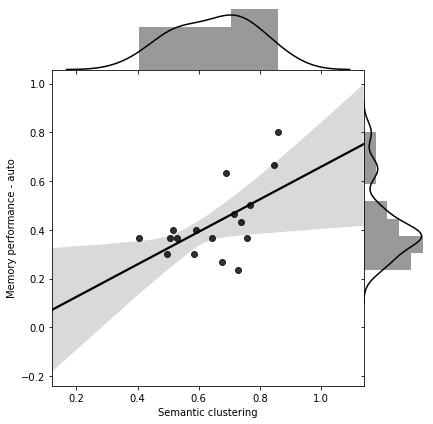

In [20]:
plot_reg(x='Semantic clustering', y='Memory performance - auto', **reg_kwargs)

## Correlation between k (number of events) and semantic clustering

Pearson's r(15) = 0.53, p = 0.027, 95% Confidence Intervals = (0.01, 0.79)


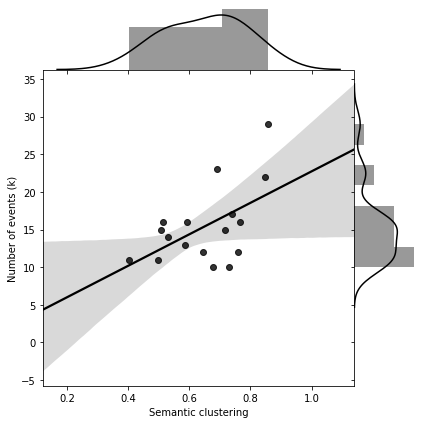

In [21]:
plot_reg(x='Semantic clustering', y='Number of events (k)', **reg_kwargs)